In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import numpy as np
from py4j.java_gateway import JavaGateway, GatewayParameters

In [2]:
# Retrieve OpenSHA objects from the JavaGateway

gateway = JavaGateway(gateway_parameters=GatewayParameters(auto_field=True, auto_convert=True))
app = gateway.entry_point
rup_set = app.loadRupSet("rupSetBruceRundir5883.zip")
sections = rup_set.getFaultSectionDataList()
coulomb = app.getCoulombTester(rup_set, "stiffnessCaches")
coulomb.setupStiffness()
agg_calc = coulomb.filters.get(1).getAggCalc()
threshold = coulomb.filters.get(1).getThreshold()

In [3]:
# Collect rupture stats

sqk = 1.0/1000000

def rupture_stats(ruptureId):
    sectionIds = rup_set.getSectionsIndicesForRup(ruptureId)
    rupture = [sections.get(s) for s in sectionIds]
    subduction = [s for s in rupture if "row:" in s.getSectionName()]
    crustal = [s for s in rupture if "row:" not in s.getSectionName()]
   # print(crustal)

    return [
        # total area of crustal component
        sum([s.getArea(False) * sqk  for s in crustal]),
        # total area of subduction component
        sum([s.getArea(False) * sqk for s in subduction]),
        # area of passing target crustal sections
        sum([s.getArea(False) * sqk for s in crustal if agg_calc.calc(subduction, [s]) >= threshold]),
        # subduction->crustal stiffness, can be used to check if filter would pass
        sum([agg_calc.calc(subduction, crustal) for s in crustal])
    ]

stats = [rupture_stats(r) for r in range(rup_set.getNumRuptures())]

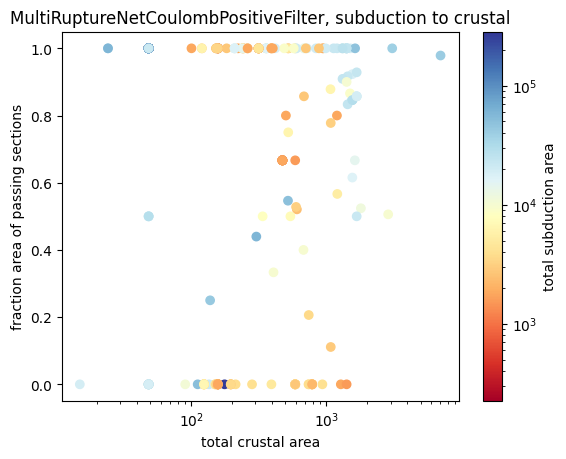

In [4]:
x = np.array([cs for (cs, ss, ps, ok) in stats])
y = np.array( [ps/cs for (cs, ss, ps, ok) in stats])
values = np.array([ss for (cs, ss, ps, ok) in stats])
plt.scatter(x, y, c=values, cmap='RdYlBu', norm=colors.LogNorm())
plt.title("MultiRuptureNetCoulombPositiveFilter, subduction to crustal")
plt.ylabel('fraction area of passing sections')
#plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')

#plt.axhline(y=0.5, color='r', linestyle='-.')
color_bar = plt.colorbar()
color_bar.set_label("total subduction area")
plt.show()

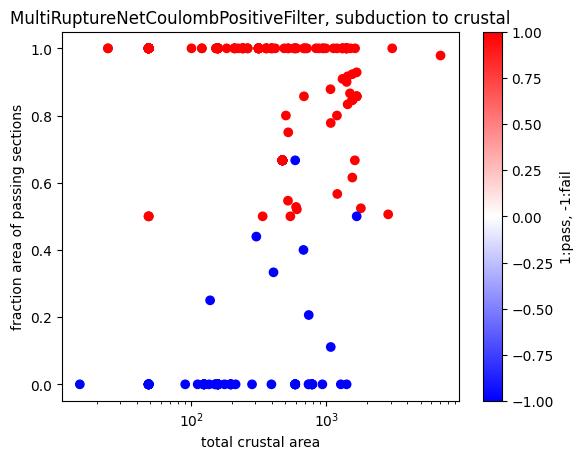

In [5]:
x = np.array([cs for (cs, ss, ps, ok) in stats])
y = np.array([ps/cs for (cs, ss, ps, ok) in stats])
cs = np.array([1 if ok>0 else -1 for (cs, ss, ps, ok) in stats])
plt.scatter(x, y, c=cs, cmap="bwr")
plt.title("MultiRuptureNetCoulombPositiveFilter, subduction to crustal")
plt.ylabel('fraction area of passing sections')
#plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')
color_bar = plt.colorbar()
color_bar.set_label("1:pass, -1:fail")
plt.show()

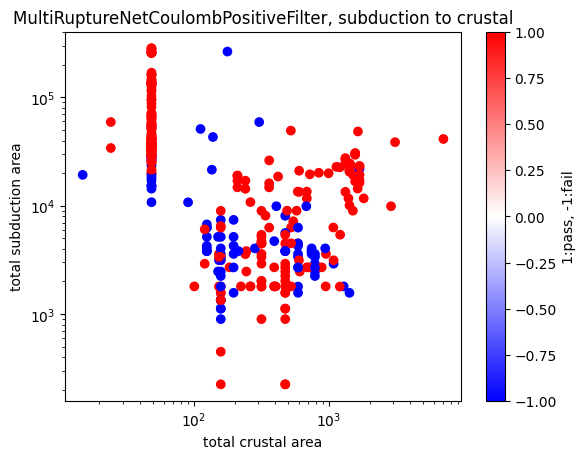

In [6]:
x = np.array([cs for (cs, ss, ps, ok) in stats])
y = np.array([ss for (cs, ss, ps, ok) in stats])
values = np.array([1 if ok>0 else -1 for (cs, ss, ps, ok) in stats])
plt.scatter(x, y, c=values, cmap="bwr")#, norm=colors.LogNorm())
plt.title("MultiRuptureNetCoulombPositiveFilter, subduction to crustal")
plt.ylabel("total subduction area")
plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')
color_bar = plt.colorbar()
color_bar.set_label("1:pass, -1:fail")
plt.show()